In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import yaml

import json
from glob import glob
import wandb
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from stats import dataset_stats

import cv2

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
os.makedirs('./assets',exist_ok=True)

# Distribution

In [4]:
def standardization(x, mean, std):
    return (x - mean) / std


def extract_data(trainset) -> np.ndarray:
    if 'data' in trainset.__dict__.keys():
        data = trainset.data.copy()
    
    else:
        data = []
        for i in tqdm(range(len(trainset)), leave=False):
            data.append(cv2.imread(trainset.imgs[i][0]))
        
        data = np.stack(data)
        
    if data.shape[1] == 3: # channel first
        data = np.transpose(data, axes=(0,2,3,1))

    return data


def compare_stats(
    datadir: str, dataname: str, img_size: int, pretrained_stats: dict, finetuning_stats: dict) -> None:
    trainset, testset = __import__('datasets').__dict__[f'load_{dataname.lower()}'](
        datadir  = datadir, 
        img_size = img_size,
        mean     = finetuning_stats['mean'], 
        std      = finetuning_stats['std']
    )
    
    data = extract_data(trainset)

    finetune_trainset = standardization(
        x = data/255,
        mean = np.array(finetuning_stats['mean']).reshape(1,1,1,3),
        std = np.array(finetuning_stats['std']).reshape(1,1,1,3)
    )

    pretrained_trainset = standardization(
        x = data/255,
        mean = np.array(pretrained_stats['mean']).reshape(1,1,1,3),
        std = np.array(pretrained_stats['std']).reshape(1,1,1,3)
    )
    print('[ Data size ]')
    print(f'Train set: {len(trainset)}, Test set: {len(testset)}')

    print('[ Finetuning setting ]')
    print('mean: ',finetune_trainset.mean(axis=(0,1,2)).round(4))
    print('std: ',finetune_trainset.std(axis=(0,1,2)).round(4))
    print()
    print('[ Pretrained setting ]')
    print('mean: ',pretrained_trainset.mean(axis=(0,1,2)).round(4))
    print('std: ',pretrained_trainset.std(axis=(0,1,2)).round(4))


In [34]:
for d in ['CIFAR10','CIFAR100','SVHN','tiny_imagenet_200']:
    print('='*20)
    print(d)
    print('='*20)
    compare_stats(
        datadir          = '/datasets/',
        dataname         = d,
        img_size         = dataset_stats[d.lower()]['img_size'],
        pretrained_stats = dataset_stats['imagenet'],
        finetuning_stats = dataset_stats[d.lower()]
    )
    print()

CIFAR10
Files already downloaded and verified
Files already downloaded and verified
[ Data size ]
Train set: 50000, Test set: 10000
[ Finetuning setting ]
mean:  [-0.     -0.0002  0.0001]
std:  [1.0001 0.9999 1.    ]

[ Pretrained setting ]
mean:  [0.0279 0.1168 0.1801]
std:  [1.0787 1.087  1.1626]

CIFAR100
Files already downloaded and verified
Files already downloaded and verified
[ Data size ]
Train set: 50000, Test set: 10000
[ Finetuning setting ]
mean:  [-0.0001 -0.0006  0.0004]
std:  [0.9994 0.9998 1.0002]

[ Pretrained setting ]
mean:  [0.0964 0.1364 0.1552]
std:  [1.1674 1.1448 1.2273]

SVHN
Using downloaded and verified file: /datasets/SVHN/train_32x32.mat
Using downloaded and verified file: /datasets/SVHN/test_32x32.mat
[ Data size ]
Train set: 73257, Test set: 26032
[ Finetuning setting ]
mean:  [-0.0001 -0.0002  0.    ]
std:  [1.0002 1.0001 1.0002]

[ Pretrained setting ]
mean:  [-0.2066 -0.0546  0.2969]
std:  [0.8648 0.8974 0.8757]

tiny_imagenet_200


[ Data size ]
Train set: 100000, Test set: 10000
[ Finetuning setting ]
mean:  [-2.992e-01 -1.000e-04  2.938e-01]
std:  [1.0188 0.9999 0.9817]

[ Pretrained setting ]
mean:  [-0.3821 -0.0354  0.3299]
std:  [1.2297 1.2003 1.2286]



# Figure

In [5]:
api = wandb.Api()

runs = api.runs('Normalization Test')

In [10]:
df_history = pd.DataFrame()

for run in runs:
    df = run.history()
    df['model'] = run.config['EXP_NAME']
    df['dataname'] = run.config['DATASET']['dataname']
    
    df_history = pd.concat([df_history, df], axis=0)

df_history.index = range(len(df_history))

name_map = {
    'resnet18'    : 'ResNet18',
    'resnet50'    : 'ResNet50',
    'densenet121' : 'DenseNet121',
    'densenet161' : 'DenseNet161'
}

def model_mapping(x: str, name_map: dict) -> str:
    name = x.split('-')[0]
    x = x.replace(name, name_map[name])
    x = x.replace('-pretrain', ' (pretrained)')
    x = x.replace('-finetune', ' (finetune)')
    x = x.replace('-instance', ' (instance)')
    x = x.replace('-minmax', ' (minmax)')

    return x
    
df_history['model'] = df_history['model'].apply(lambda x: model_mapping(x, name_map))

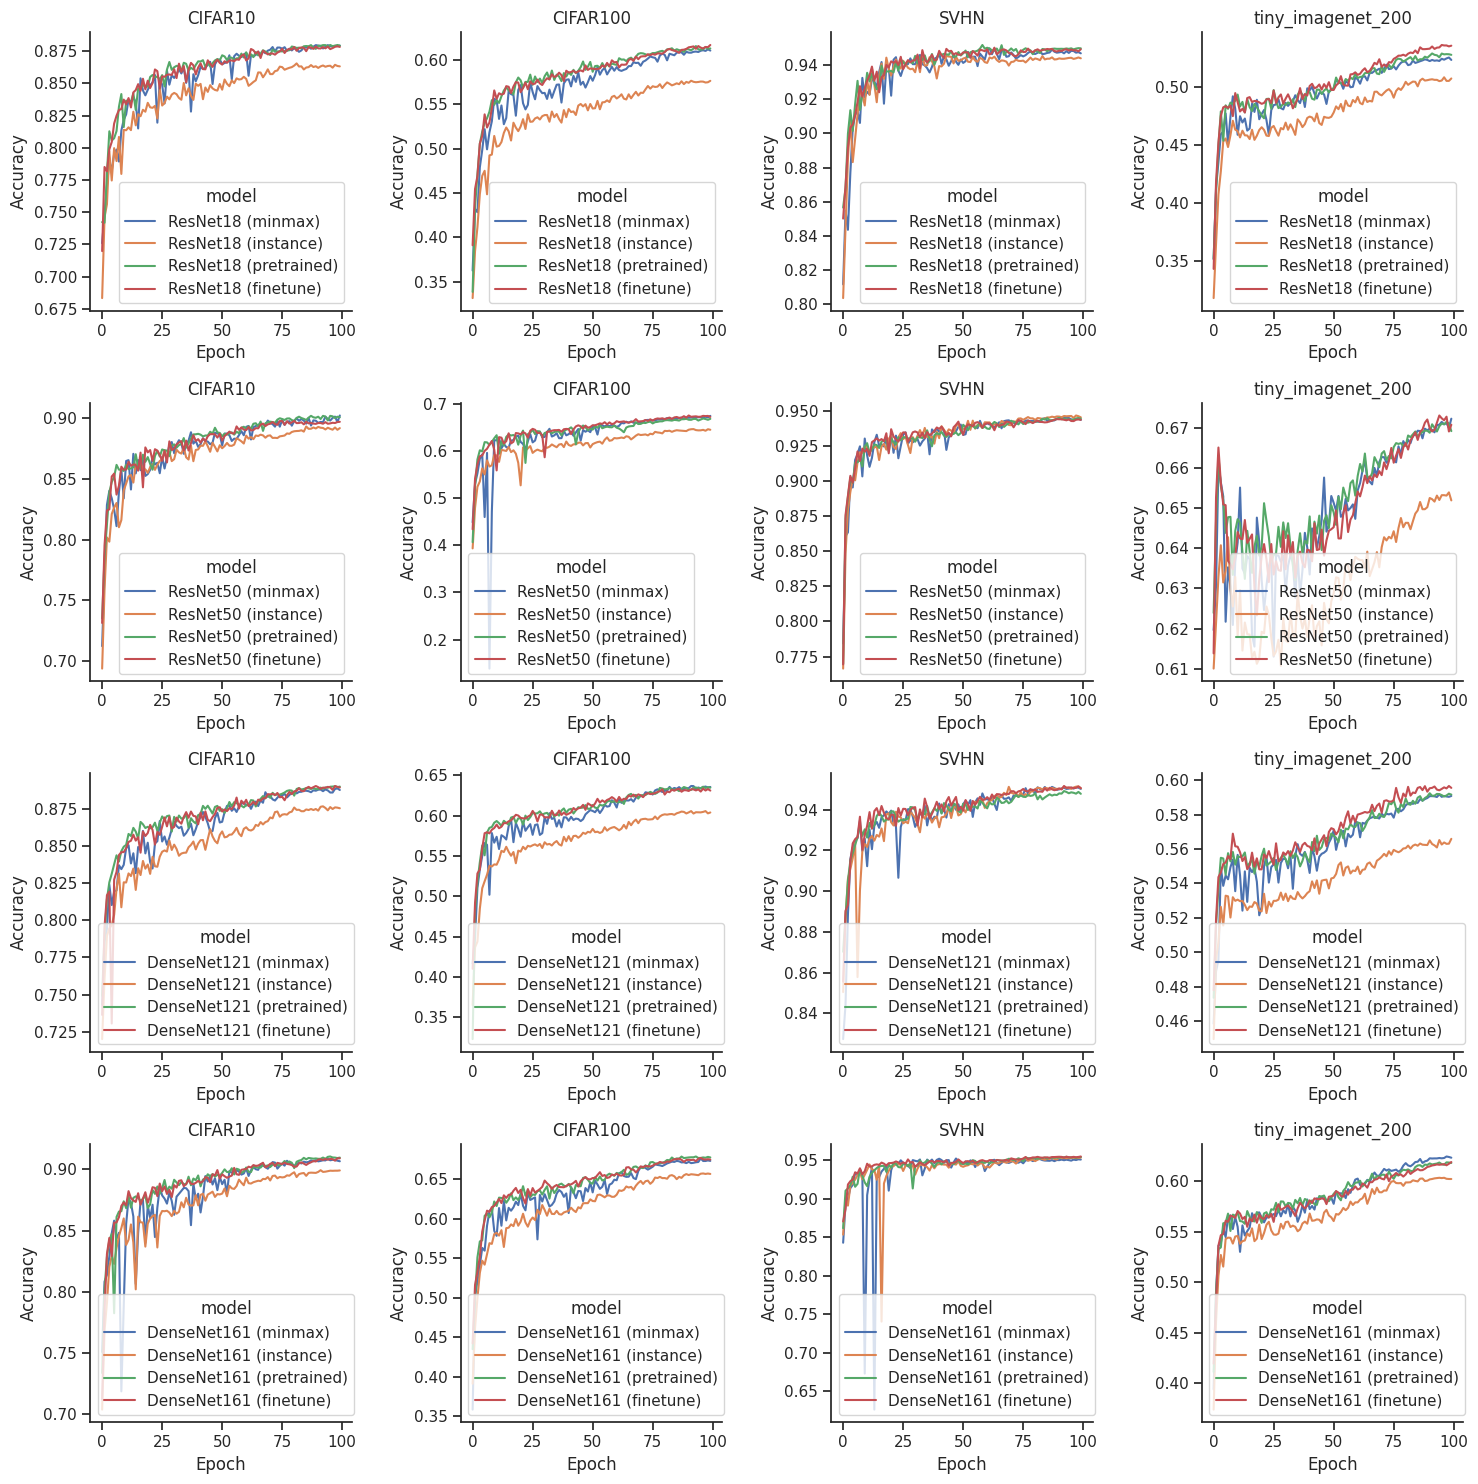

In [25]:
normalize_list = ['pretrained','finetune','instance','minmax']
model_list = [[f'{m} ({n})' for n in normalize_list] for m in name_map.values()]
data_list = ['CIFAR10', 'CIFAR100','SVHN','tiny_imagenet_200']

fig, ax = plt.subplots(len(model_list), len(data_list), figsize=(15,15))

for c, d in enumerate(data_list):
    for r, m in enumerate(model_list):
        sns.lineplot(
            x    = '_step',
            y    = 'eval_acc',
            hue  = 'model',
            data = df_history[(df_history['dataname']==d) & (df_history['model'].isin(m))],
            ax   = ax[r, c]
        )
        ax[r, c].set_ylabel('Accuracy')
        ax[r, c].set_xlabel('Epoch')
        ax[r, c].set_title(d)

plt.tight_layout()
plt.savefig('./assets/figure1.jpg', dpi=300)

# Table

In [26]:
model_list = os.listdir('./saved_model/')
results_list = glob('./saved_model/*/*/best_results.json')

In [27]:
# load results
dataname_list = []
model_list = []
acc_list = []

for r_path in results_list:
    dataname, model = r_path.split('/')[-3:-1]
    
    dataname_list.append(dataname)
    model_list.append(model)
    acc_list.append(json.load(open(r_path, 'r'))['best_acc'])

# make dataframe
df_results = pd.DataFrame({
    'dataname' : dataname_list,
    'expname'  : model_list,
    'acc'      : acc_list

})

# split expname into model and setting
df_results['model'] = df_results['expname'].apply(lambda x: x.split('-')[0])
df_results['setting'] = df_results['expname'].apply(lambda x: x.split('-')[1])

# change model name
df_results['model'] = df_results['model'].map(name_map)

# drop expname
df_results = df_results.drop('expname', axis=1)

df_results = df_results.set_index(['model','setting','dataname']).sort_index().unstack(level=2).round(4)

In [28]:
df_results.to_csv('./assets/table1.csv')

In [29]:
df_results

acc                                   
dataname             CIFAR10 CIFAR100    SVHN tiny_imagenet_200
model       setting                                            
DenseNet121 finetune  0.8905   0.6334  0.9516            0.5966
            instance  0.8768   0.6056  0.9515            0.5659
            minmax    0.8889   0.6367  0.9512            0.5917
            pretrain  0.8903   0.6358  0.9491            0.5924
DenseNet161 finetune  0.9091   0.6768  0.9551            0.6190
            instance  0.8994   0.6572  0.9537            0.6034
            minmax    0.9087   0.6763  0.9525            0.6245
            pretrain  0.9106   0.6787  0.9546            0.6187
ResNet18    finetune  0.8788   0.6167  0.9501            0.5362
            instance  0.8655   0.5764  0.9455            0.5083
            minmax    0.8797   0.6118  0.9497            0.5254
            pretrain  0.8798   0.6155  0.9517            0.5289
ResNet50    finetune  0.8978   0.6758  0.9439            0.6732
            instance  0.8932   0.6469  0.9465            0.6540
            minmax    0.9023   0.6750  0.9449            0.6724
            pretrain  0.9020   0.6694  0.9448            0.6716

In [30]:
print(df_results.reset_index().to_markdown())

|    | ('model', '')   | ('setting', '')   |   ('acc', 'CIFAR10') |   ('acc', 'CIFAR100') |   ('acc', 'SVHN') |   ('acc', 'tiny_imagenet_200') |
|---:|:----------------|:------------------|---------------------:|----------------------:|------------------:|-------------------------------:|
|  0 | DenseNet121     | finetune          |               0.8905 |                0.6334 |            0.9516 |                         0.5966 |
|  1 | DenseNet121     | instance          |               0.8768 |                0.6056 |            0.9515 |                         0.5659 |
|  2 | DenseNet121     | minmax            |               0.8889 |                0.6367 |            0.9512 |                         0.5917 |
|  3 | DenseNet121     | pretrain          |               0.8903 |                0.6358 |            0.9491 |                         0.5924 |
|  4 | DenseNet161     | finetune          |               0.9091 |                0.6768 |            0.9551 |                   

## Model Desc

In [27]:
from timm import create_model

In [28]:
cifar10_params = []
cifar100_params = []

for m in name_map.keys():
    model = create_model(m, num_classes=10)
    cifar10_params.append(sum([p.numel() for p in model.parameters()]))
    
    model = create_model(m, num_classes=100)
    cifar100_params.append(sum([p.numel() for p in model.parameters()]))

In [29]:
model_desc =pd.DataFrame({
    'model'             : name_map.values(),
    '#Params (CIFAR10)' : cifar10_params,
    '#Params (CIFAR100)': cifar100_params
})

In [30]:
print(model_desc.to_markdown())

|    | model       |   #Params (CIFAR10) |   #Params (CIFAR100) |
|---:|:------------|--------------------:|---------------------:|
|  0 | ResNet18    |            11181642 |             11227812 |
|  1 | ResNet50    |            23528522 |             23712932 |
|  2 | DenseNet121 |             6964106 |              7056356 |
|  3 | DenseNet161 |            26494090 |             26692900 |
